# T81-558: Applications of Deep Neural Networks
**Class 13: Advanced/Other Topics**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

Tonight I will cover several advanced features of TensorFlow.  This is mostly a collection of additional topics that did not fit nicely into other sections of the course.  Topics include:

* Multi-Output Regression
* Autoencoders
* Python Image Handling
* Image Autoencoders
* Denoising Autoencoders

# Common Functions

In [6]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=False):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Function Approximation


Actual
[[ 0.00071864]
 [ 0.01803382]
 [ 0.11465593]
 [ 0.1213861 ]
 [ 0.1712333 ]]
Pred
[[ 0.00450796]
 [ 0.02547958]
 [ 0.12125494]
 [ 0.12840533]
 [ 0.17297691]]


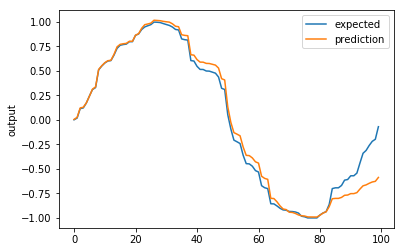

In [12]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

rng = np.random.RandomState(1)
x = np.sort((360 * rng.rand(100, 1)), axis=0)
y = np.array([np.sin(x*(np.pi/180.0)).ravel()]).T

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x,y,verbose=0,epochs=1500)

pred = model.predict(x)

print("Actual")
print(y[0:5])

print("Pred")
print(pred[0:5])

chart_regression(pred.flatten(),y)

# Multi-Output Regression

Unlike most models, neural networks can provide multiple regression outputs.  This allows a neural network to generate multiple outputs for the same input.  For example, the MPG data set might be trained to predict both MPG and horsepower.  One area that multiple regression outputs can be useful for is auto encoders.  The following diagram shows a multi-regression neural network.  As you can see, there are multiple output neurons.  Usually multiple output neurons are used for classification.  However, in this case it is a regression neural network.

![Multi-Output Regression](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_13_multi_output.png "Multi-Output Regression")

The following program uses a multi-output regression to predict both [sin](https://en.wikipedia.org/wiki/Trigonometric_functions#Sine.2C_cosine_and_tangent) and [cos](https://en.wikipedia.org/wiki/Trigonometric_functions#Sine.2C_cosine_and_tangent) from the same input data.

In [16]:
from sklearn import metrics

rng = np.random.RandomState(1)
x = np.sort((360 * rng.rand(100, 1)), axis=0)
y = np.array([np.pi * np.sin(x*(np.pi/180.0)).ravel(), np.pi * np.cos(x*(np.pi/180.0)).ravel()]).T

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, kernel_initializer='normal')) # Two output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x,y,verbose=0,epochs=5000)

# Fit regression DNN model.
pred = model.predict(x)

score = np.sqrt(metrics.mean_squared_error(pred, y))
print("Score (RMSE): {}".format(score))

np.set_printoptions(suppress=True)

print("Predicted:")
print(np.array(pred[0:5]))

print("Expected:")
print(np.array(y[0:5]))


Score (RMSE): 0.08488867949468645
Predicted:
[[ 0.00857823  3.15231204]
 [ 0.06306653  3.14830041]
 [ 0.36788726  3.12586093]
 [ 0.38921249  3.12428927]
 [ 0.5466423   3.10605311]]
Expected:
[[ 0.00225767  3.14159184]
 [ 0.05665491  3.14108176]
 [ 0.36020222  3.12087468]
 [ 0.38134567  3.11836173]
 [ 0.53794528  3.09519293]]


# Simple Auto Encoder

An auto encoder is a neural network that has the same number of input neurons as it does outputs.  The hidden layers of the neural network will have fewer neurons than the input/output neurons.  Because there are fewer neurons, the auto-encoder must learn to encode the input to the fewer hidden neurons.  The predictors (x) and output (y) are exactly the same in an auto encoder.  Because of this, auto encoders are said to be unsupervised.  

![Simple Auto Encoder](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_13_auto_encode.png "Simple Auto Encoder")

The following program demonstrates a very simple auto encoder that learns to encode a sequence of numbers.  Fewer hidden neurons will make it much more difficult for the auto encoder to learn.

In [22]:
from sklearn import metrics
import numpy as np
import pandas as pd
from IPython.display import display, HTML 
import tensorflow as tf

x = np.array([range(10)]).astype(np.float32)

model = Sequential()
model.add(Dense(3, input_dim=x.shape[1], activation='relu'))
model.add(Dense(x.shape[1], kernel_initializer='normal')) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x,x,verbose=0,epochs=1000)

pred = model.predict(x)
score = np.sqrt(metrics.mean_squared_error(pred,x))
print("Fold score (RMSE): {}".format(score))
np.set_printoptions(suppress=True)
print(pred)

Fold score (RMSE): 5.6641351875441615e-06
[[-0.          1.          2.          3.00000143  4.00000334  5.00000381
   6.00000858  7.00000811  7.9999876   9.        ]]


# Reading Images in Python

We will make use of images to demonstrate auto encoders.  To use images in Python, we will make use of the Pillow package.  This package can be installed with the following command.  

```
pip install pillow
```

The following program uses Pillow to load and display an image.

[[[ 86 133 177]
  [ 85 132 176]
  [ 84 133 176]
  ..., 
  [ 94 128 153]
  [ 91 128 155]
  [ 94 129 169]]

 [[ 86 133 177]
  [ 88 135 179]
  [ 88 137 180]
  ..., 
  [ 96 133 159]
  [ 92 136 165]
  [ 99 141 183]]

 [[ 83 130 174]
  [ 87 134 178]
  [ 89 138 181]
  ..., 
  [108 150 175]
  [100 149 179]
  [ 97 144 186]]

 ..., 
 [[127  77  76]
  [131  81  80]
  [128  80  76]
  ..., 
  [  4  10  10]
  [  2  11  10]
  [  2  11  10]]

 [[132  81  77]
  [129  80  75]
  [124  75  70]
  ..., 
  [  4  10  10]
  [  3  12  11]
  [  3  12  11]]

 [[140  90  83]
  [137  87  80]
  [130  81  74]
  ..., 
  [ 11  17  17]
  [ 10  19  18]
  [ 10  19  18]]]


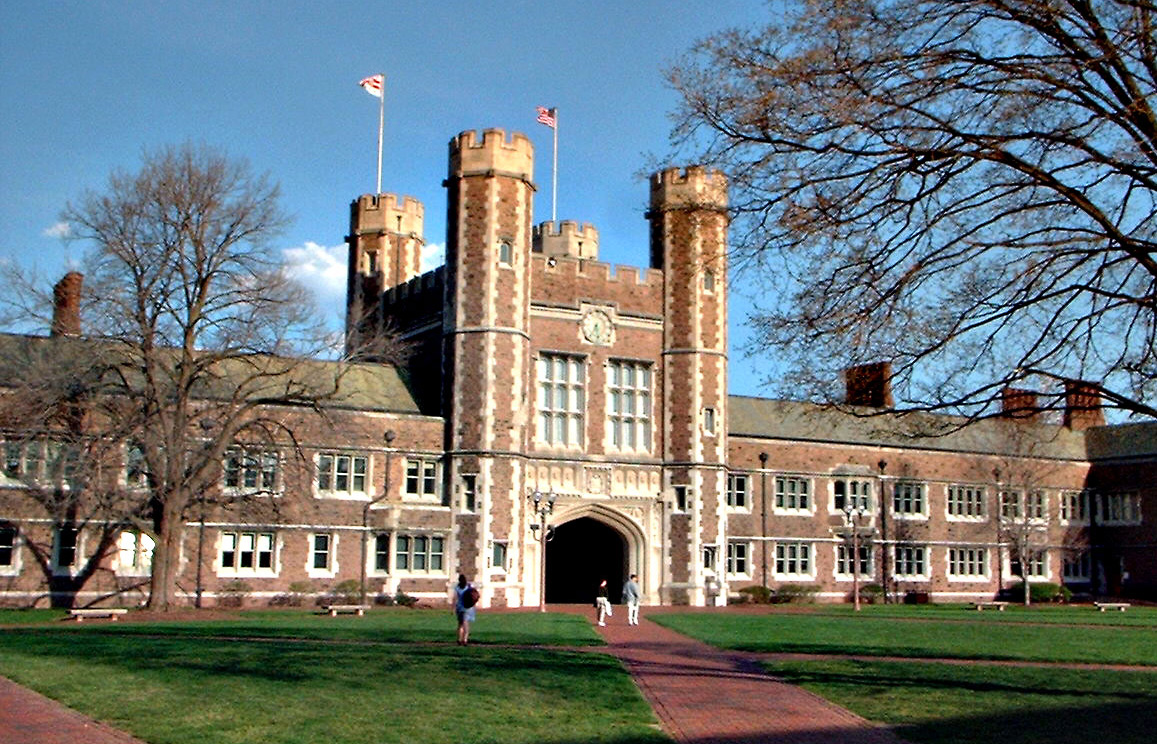

In [23]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

%matplotlib inline

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

print(np.asarray(img))

img

# Creating Images (from pixels) in Python


Pillow can also be used to create an image from a 3D numpy cube.  The rows and columns specify the pixels.  The depth, of 3, specifies red, green and blue.  Here a simple image is created.

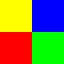

In [8]:
from PIL import Image
import numpy as np

w, h = 64, 64
data = np.zeros((h, w, 3), dtype=np.uint8)

# Yellow
for row in range(32):
    for col in range(32):
        data[row,col] = [255,255,0]
        
# Red
for row in range(32):
    for col in range(32):
        data[row+32,col] = [255,0,0]
        
# Green
for row in range(32):
    for col in range(32):
        data[row+32,col+32] = [0,255,0]        
        
# Blue
for row in range(32):
    for col in range(32):
        data[row,col+32] = [0,0,255]                
        

img = Image.fromarray(data, 'RGB')
img

# Transform Images in Python (at the pixel level)

We can combine the last two programs and modify images.  Here we take the mean color of each pixel and form a grayscale image.

Rows: 744, Cols: 1157


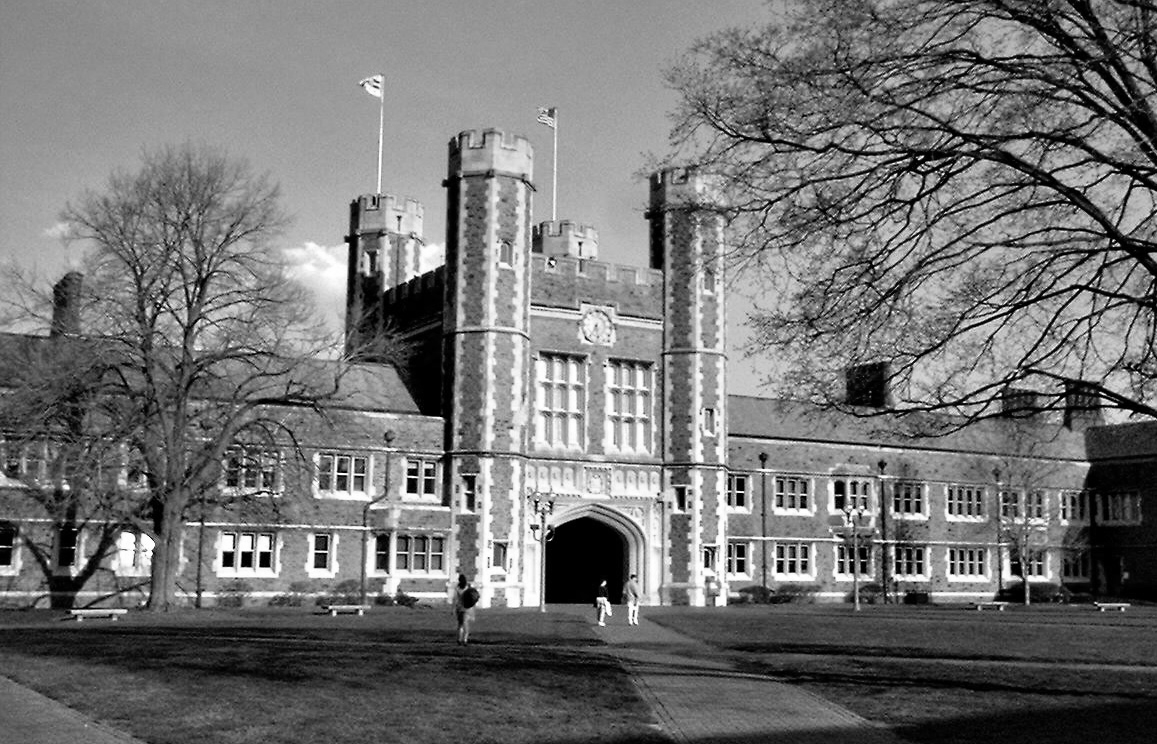

In [6]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

%matplotlib inline

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg"
#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

img_array = np.asarray(img)
rows = img_array.shape[0]
cols = img_array.shape[1]

print("Rows: {}, Cols: {}".format(rows,cols))

# Create new image
img2_array = np.zeros((rows, cols, 3), dtype=np.uint8)
for row in range(rows):
    for col in range(cols):
        t = np.mean(img_array[row,col])
        img2_array[row,col] = [t,t,t]

img2 = Image.fromarray(img2_array, 'RGB')
img2        
        

# Auto Encode (single image)

We are now ready to build a simple image auto encoder.  The program below learns an effective encoding for the image.  You can see the distortions that occur.

49152
[[  84.  134.  177. ...,    6.   15.   14.]]
Neural network output
[[ 108.60673523  144.71871948  168.33251953 ...,    7.6273551    20.79152679
    35.67477036]]
[[  84.  134.  177. ...,    6.   15.   14.]]


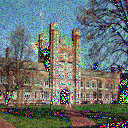

In [52]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
from keras.optimizers import SGD
import requests
from io import BytesIO

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg"
    
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()
img = img.resize((128,128), Image.ANTIALIAS)
img_array = np.asarray(img)
img_array = img_array.flatten()
img_array = np.array([ img_array ])
img_array = img_array.astype(np.float32)
print(img_array.shape[1])
print(img_array)

model = Sequential()
model.add(Dense(10, input_dim=img_array.shape[1], activation='relu'))
model.add(Dense(img_array.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(img_array,img_array,verbose=0,epochs=20)

print("Neural network output")
pred = model.predict(img_array)
print(pred)
print(img_array)
cols,rows = img.size
img_array2 = pred[0].reshape(rows,cols,3)
img_array2 = img_array2.astype(np.uint8)
img2 = Image.fromarray(img_array2, 'RGB')
img2   

# Standardize Images

When processing several images together it is sometimes important to standardize them.  The following code reads a sequence of images and causes them to all be of the same size and perfectly square.  If the input images are not square, cropping will occur.

https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg


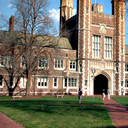

https://upload.wikimedia.org/wikipedia/commons/f/ff/WashU_Graham_Chapel.JPG


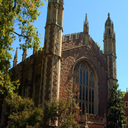

https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg


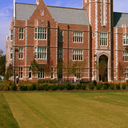

https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg


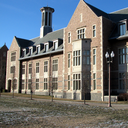

https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg


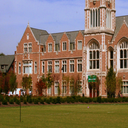

https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg


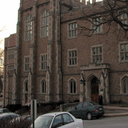

https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg


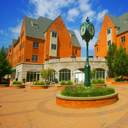

(7, 49152)


In [53]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML

#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

images = [
    "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/ff/WashU_Graham_Chapel.JPG",
    "https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg"    
]


def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/2
        img = img.crop((pad,0,cols,cols))
    else:
        pad = (cols-rows)/2
        img = img.crop((0,pad,rows,rows))
    
    return img
    
x = [] 
    
for url in images:
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.load()
    img = make_square(img)
    img = img.resize((128,128), Image.ANTIALIAS)
    print(url)
    display(img)
    img_array = np.asarray(img)
    img_array = img_array.flatten()
    img_array = img_array.astype(np.float32)
    img_array = (img_array-128)/128
    x.append(img_array)
    

x = np.array(x)

print(x.shape)


# Image Auto Encoder (multi-image)

Auto encoders can learn the same encoding for multiple images.  The following code learns a single encoding for multiple images. 

Creating/Training neural network
Score neural network
[-0.15572815  0.2699205   0.64845508 ..., -0.88700104 -0.96510363
 -0.83675474]


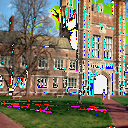

[ 0.13050701  0.06011012 -0.9827984  ..., -0.62169898 -0.808492   -0.92216468]


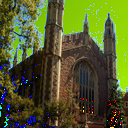

[-0.12348396  0.11953723  0.86666214 ...,  0.15055595 -0.15926607
 -0.66016304]


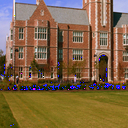

[-0.40610442  0.08343485  0.65935344 ..., -0.12783974 -0.23178719
 -0.34730053]


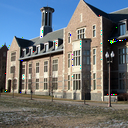

[ 0.31388572  0.40552548  0.83490509 ..., -0.20730036 -0.27850485
 -0.8668744 ]


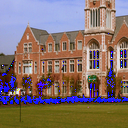

[ 1.06394458  1.06044543  1.08374584 ..., -0.18585901 -0.21333247
 -0.21845655]


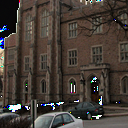

[-0.7805655  -0.37561208  0.5442732  ...,  0.65302277  0.20815048
 -0.34583819]


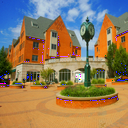

In [58]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
from sklearn import metrics
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display, HTML 

# Fit regression DNN model.
print("Creating/Training neural network")
model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(x.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,x,verbose=0,epochs=100)

print("Score neural network")
pred = model.predict(x)

cols,rows = img.size
for i in range(len(pred)):
    print(pred[i])
    img_array2 = pred[i].reshape(rows,cols,3)
    img_array2 = (img_array2*128)+128
    img_array2 = img_array2.astype(np.uint8)
    img2 = Image.fromarray(img_array2, 'RGB')
    display(img2)   

# Adding Noise to an Image

Auto encoders can handle noise.  First it is important to see how to add noise to an image.  There are many ways to add such noise.  The following code adds random black squares to the image to produce noise.

Rows: 744, Cols: 1157
(744, 1157, 3)


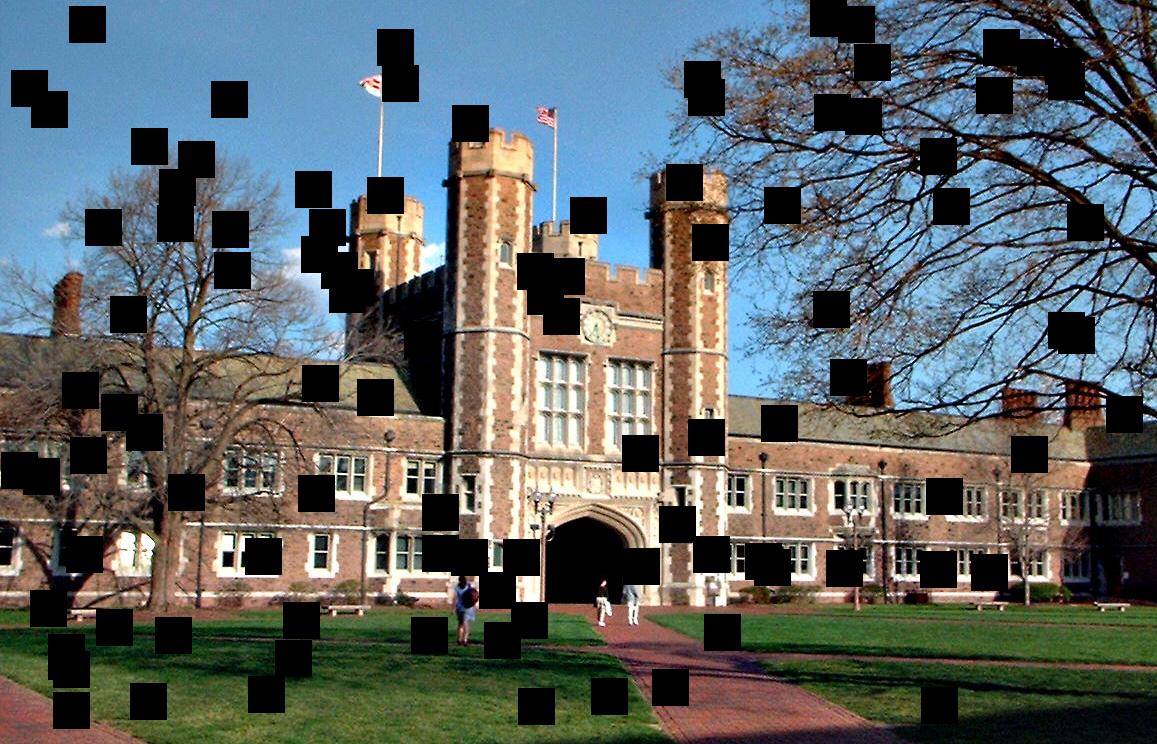

In [59]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

%matplotlib inline


def add_noise(a):
    a2 = a.copy()
    rows = a2.shape[0]
    cols = a2.shape[1]
    s = int(min(rows,cols)/20) # size of spot is 1/20 of smallest dimension
    
    for i in range(100):
        x = np.random.randint(cols-s)
        y = np.random.randint(rows-s)
        a2[y:(y+s),x:(x+s)] = 0
        
    return a2

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg"
#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

img_array = np.asarray(img)
rows = img_array.shape[0]
cols = img_array.shape[1]

print("Rows: {}, Cols: {}".format(rows,cols))

# Create new image
img2_array = img_array.astype(np.uint8)
print(img2_array.shape)
img2_array = add_noise(img2_array)
img2 = Image.fromarray(img2_array, 'RGB')
img2        
        

# Denoising Autoencoder

A denoising auto encoder is designed to remove noise from input signals.  To do this the $y$ becomes each image/signal (just like a normal auto encoder), however, the $x$ becomes a version of $y$ with noise added.  Noise is artificially added to the images to produce $x$.  The following code creates 10 noisy version of each of the images.  The network is trained to convert noisy data ($x$) to the origional input ($y$).

https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg


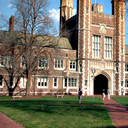

https://upload.wikimedia.org/wikipedia/commons/f/ff/WashU_Graham_Chapel.JPG


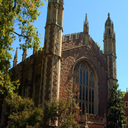

https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg


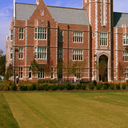

https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg


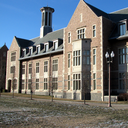

https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg


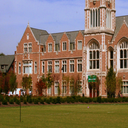

https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg


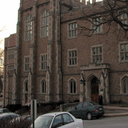

https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg


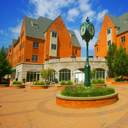

(70, 49152)
(70, 49152)


In [60]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML

#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

images = [
    "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/ff/WashU_Graham_Chapel.JPG",
    "https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg"    
]


def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/2
        img = img.crop((pad,0,cols,cols))
    else:
        pad = (cols-rows)/2
        img = img.crop((0,pad,rows,rows))
    
    return img
    
x = []    
y = []
loaded_images = []
    
for url in images:
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.load()
    img = make_square(img)
    img = img.resize((128,128), Image.ANTIALIAS)
    
    loaded_images.append(img)
    print(url)
    display(img)
    for i in range(10):
        img_array = np.asarray(img)
        img_array_noise = add_noise(img_array)
        
        img_array = img_array.flatten()
        img_array = img_array.astype(np.float32)
        img_array = (img_array-128)/128
        
        img_array_noise = img_array_noise.flatten()
        img_array_noise = img_array_noise.astype(np.float32)
        img_array_noise = (img_array_noise-128)/128
        
        x.append(img_array_noise)
        y.append(img_array)
    
x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)


In [70]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
from sklearn import metrics
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display, HTML 

# Fit regression DNN model.
print("Creating/Training neural network")
model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(x.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=1,epochs=20)

print("Neural network trained")


Creating/Training neural network
[[-0.140625   0.25       0.5859375 ..., -0.8046875 -0.859375  -0.75     ]
 [-0.140625   0.25       0.5859375 ..., -0.8046875 -0.859375  -0.75     ]
 [-0.140625   0.25       0.5859375 ..., -0.8046875 -0.859375  -0.75     ]
 ..., 
 [-0.7890625 -0.390625   0.53125   ...,  0.6484375  0.203125  -0.3515625]
 [-0.7890625 -0.390625   0.53125   ...,  0.6484375  0.203125  -0.3515625]
 [-0.7890625 -0.390625   0.53125   ...,  0.6484375  0.203125  -0.3515625]]
Epoch 1/20
70/70 [==============================] - 2s - loss: 0.2699     
Epoch 2/20
70/70 [==============================] - 1s - loss: 0.1941     
Epoch 3/20
70/70 [==============================] - 1s - loss: 0.1539     

*** Trial 1
With noise:


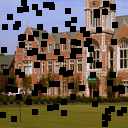

After auto encode noise removal


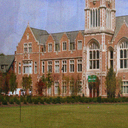

*** Trial 2
With noise:


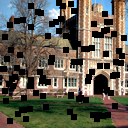

After auto encode noise removal


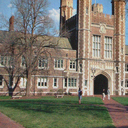

*** Trial 3
With noise:


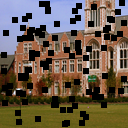

After auto encode noise removal


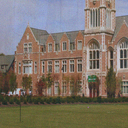

*** Trial 4
With noise:


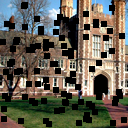

After auto encode noise removal


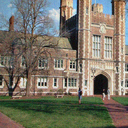

*** Trial 5
With noise:


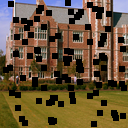

After auto encode noise removal


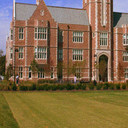

*** Trial 6
With noise:


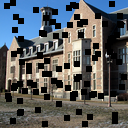

After auto encode noise removal


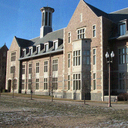

*** Trial 7
With noise:


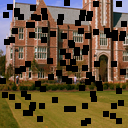

After auto encode noise removal


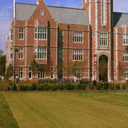

*** Trial 8
With noise:


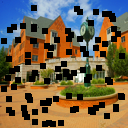

After auto encode noise removal


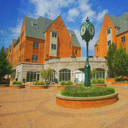

*** Trial 9
With noise:


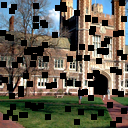

After auto encode noise removal


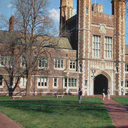

*** Trial 10
With noise:


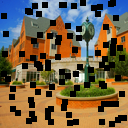

After auto encode noise removal


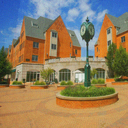

In [71]:
for z in range(10):
    print("*** Trial {}".format(z+1))
    
    # Choose random image
    i = np.random.randint(len(loaded_images))
    img = loaded_images[i]
    img_array = np.asarray(img)
    cols, rows = img.size

    # Add noise
    img_array_noise = add_noise(img_array)    

    #Display noisy image
    img2 = img_array_noise.astype(np.uint8)
    img2 = Image.fromarray(img2, 'RGB')
    print("With noise:")
    display(img2)

    # Present noisy image to auto encoder
    img_array_noise = img_array_noise.flatten()
    img_array_noise = img_array_noise.astype(np.float32)
    img_array_noise = (img_array_noise-128)/128
    img_array_noise = np.array([img_array_noise])
    pred = model.predict(img_array_noise)[0]

    # Display neural result
    img_array2 = pred.reshape(rows,cols,3)
    img_array2 = (img_array2*128)+128
    img_array2 = img_array2.astype(np.uint8)
    img2 = Image.fromarray(img_array2, 'RGB')
    print("After auto encode noise removal")
    display(img2)

# TSNE

T-SNE is a dimension reduction algorithm that is very often used for 2D and 3D data visualization.  This algorithm is defined in the following paper:

* [Visualizing Data using t-SNE](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

The following links shows T-SNE used in 3D.

* [T-SNE in 3D](https://www.youtube.com/watch?v=s7PKqXD2drs)



Automatically created module for IPython interactive environment
Computing PCA projection
Computing t-SNE embedding


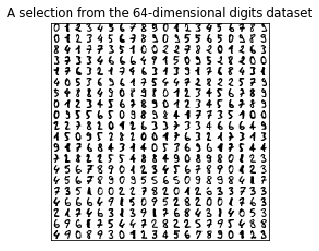

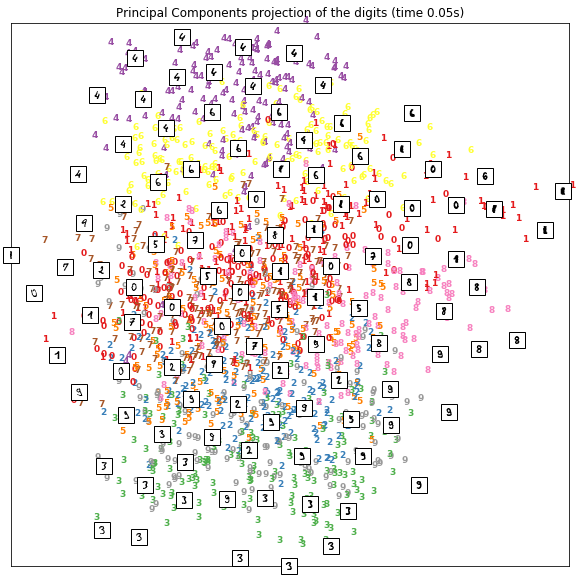

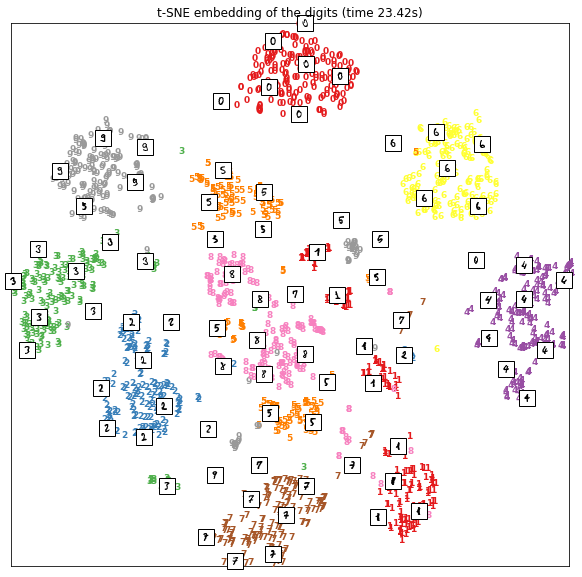

In [35]:
%matplotlib inline
# Based on code by: 
#          Fabian Pedregosa <fabian.pedregosa@inria.fr>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#          Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2011

print(__doc__)
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

digits = datasets.load_digits(n_class=10)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30


#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


#----------------------------------------------------------------------
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')


#----------------------------------------------------------------------
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))


#----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

# Other Topics

### Reinforcement Learning

Reinforcement learning is an area of machine learning inspired by behaviorist psychology, concerned with how software agents ought to take actions in an environment so as to maximize some notion of cumulative reward. The problem, due to its generality, is studied in many other disciplines, such as game theory, control theory, operations research, information theory, simulation-based optimization, multi-agent systems, swarm intelligence, statistics, and genetic algorithms. In the operations research and control literature, the field where reinforcement learning methods are studied is called approximate dynamic programming. The problem has been studied in the theory of optimal control, though most studies are concerned with the existence of optimal solutions and their characterization, and not with the learning or approximation aspects. In economics and game theory, reinforcement learning may be used to explain how equilibrium may arise under bounded rationality. (from Wikipedia)

The following links discuss reinforcement learning:

* [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)
* [Deep Reinforcement Learning: Pong from Pixels](http://karpathy.github.io/2016/05/31/rl/)
